In [58]:
import numpy as np
import pandas as pd
import pickle

In [59]:
def load_dataset(dsname):
    metadata = pd.read_csv(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/metadata_final.csv")
    x = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data0.p", "rb" ))
    y = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_labels.p", "rb" ))
    return metadata, x, y

In [60]:
from sklearn.preprocessing import StandardScaler

def standardize(data):
    scaler = StandardScaler()
    n = data.shape
    return scaler.fit_transform(data.reshape(n[0],-1)).reshape(n)

In [61]:
datasets = ["emodb", "emovo", "ravdess"]
data = {}
for d in datasets:
    md, x, y = load_dataset(d)
    data[d] = {}
    data[d]["x"] = standardize(x)
    data[d]["y"] = y
    data[d]["metadata"] = md

Get train/test data

In [62]:
from sklearn.model_selection import train_test_split

train = {}
test = {}
for d in datasets:
    train[d] = {}
    test[d] = {}
    train_df, test_df = train_test_split(data[d]['metadata'], 
                                       test_size = 0.2, 
                                       random_state = 1938,
                                       stratify = data[d]['metadata']['label'])
    train_index = train_df.index
    test_index = test_df.index
    train[d]['x'] = data[d]['x'][train_index]
    train[d]['y'] = data[d]['y'][train_index]
    test[d]['x']= data[d]['x'][test_index]
    test[d]['y']= data[d]['y'][test_index]
    

In [63]:
data['emodb']['y'].shape, train['emodb']['y'].shape, test['emodb']['y'].shape

((4181, 5), (3344, 5), (837, 5))

# Model hyperparameter

Find the optimal number of LSTM unit for each dataset

In [64]:
import tensorflow as tf
import tensorflow.keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

In [96]:
def get_m1(hp):
    # Define hyper model architecture
    m = Sequential([
        InputLayer(input_shape=(261,128,1)),
        Reshape((9,29,128,1)),
        TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

        TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

        TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        TimeDistributed(Flatten()),
        
        # Tune number of units (4, 8, 16, 32, 64, 128, 256, 512, 1024)
        Bidirectional(LSTM(hp.Choice("lstm_units",  values=[4, 8, 16, 32, 64, 128, 256, 512, 1024]),
                           dropout=0.2,
                           return_sequences=False)),
        Dense(5, activation='softmax')
    ])
    
    
    # Define optimizer, loss, and metrics
    m.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])
    return m

In [97]:
def search_lstm(ds):
    # instantiate the tuner
    tuner = kt.tuners.Hyperband(get_m1,
                                objective="val_loss",
                                max_epochs=120,
                                # number of models that should be built and fit for each trial with the same hyperparameter values
                                executions_per_trial=3,
                                # the reduction factor for the number of epochs and number of models for each bracket
                                factor=15,
                                # the number of times to iterate over the full Hyperband algorithm
                                hyperband_iterations=3,
                                overwrite=True,
                                directory="/datasets/nicolas_facchinetti/kt_dir1",
                                project_name="cnnlstm1")

    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')

    tuner.search(train[ds]['x'], train[ds]['y'],
                 epochs=100,
                 validation_split=0.2,
                 callbacks=[earlyStopping, reduce_lr_loss],
                 verbose=2)

    tuner.results_summary()

In [98]:
res1 = search_lstm('emodb')

Trial 9 Complete [00h 00m 44s]
val_loss: 0.8164869149525961

Best val_loss So Far: 0.2773245970408122
Total elapsed time: 00h 07m 08s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /datasets/nicolas_facchinetti/kt_dir1/cnnlstm1
Showing 10 best trials
Trial summary
Hyperparameters:
lstm_units: 1024
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.2773245970408122
Trial summary
Hyperparameters:
lstm_units: 256
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.27998746434847516
Trial summary
Hyperparameters:
lstm_units: 512
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.28713759779930115
Trial summary
Hyperparameters:
lstm_units: 128
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.30227017402648926
Trial summary
Hyperparameters:
lstm_units: 64
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3317890167236328
Trial su

In [99]:
res2 = search_lstm('emovo')

Trial 8 Complete [00h 00m 49s]
val_loss: 0.9167342185974121

Best val_loss So Far: 0.469268798828125
Total elapsed time: 00h 07m 20s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /datasets/nicolas_facchinetti/kt_dir1/cnnlstm1
Showing 10 best trials
Trial summary
Hyperparameters:
lstm_units: 256
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.469268798828125
Trial summary
Hyperparameters:
lstm_units: 512
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.47502759099006653
Trial summary
Hyperparameters:
lstm_units: 1024
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.4843284785747528
Trial summary
Hyperparameters:
lstm_units: 128
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5031256278355917
Trial summary
Hyperparameters:
lstm_units: 64
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5940326849619547
Trial summar

In [100]:
res3 = search_lstm('ravdess')

Trial 9 Complete [00h 01m 12s]
val_loss: 0.9822319944699606

Best val_loss So Far: 0.31175460418065387
Total elapsed time: 00h 11m 46s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /datasets/nicolas_facchinetti/kt_dir1/cnnlstm1
Showing 10 best trials
Trial summary
Hyperparameters:
lstm_units: 512
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.31175460418065387
Trial summary
Hyperparameters:
lstm_units: 1024
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3192315498987834
Trial summary
Hyperparameters:
lstm_units: 256
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3441995580991109
Trial summary
Hyperparameters:
lstm_units: 128
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.41606780886650085
Trial summary
Hyperparameters:
lstm_units: 64
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.48048003514607746
Trial s

Going with 256 LSTM units enure great perfomance boost with a lower risk of overfitting

In [101]:
def get_m():
    # Define hyper model architecture
    m = Sequential([
        InputLayer(input_shape=(261,128,1)),
        Reshape((9,29,128,1)),
        TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

        TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

        TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        TimeDistributed(Flatten()),
        
        Bidirectional(LSTM(256,
                           dropout=0.2,
                           return_sequences=False)),
        Dense(5, activation='softmax')
    ])
    
    
    return m

get_m().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_10 (TimeDis (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 9, 2, 27, 64)     

### Test LSTM architecture

In [107]:
def train_evaluate(ds):
    m = get_m()
    m.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')
    
    # fit & predict
    history = m.fit(train[ds]['x'], train[ds]['y'],
                    epochs=50,
                    batch_size=32,
                    callbacks=[earlyStopping, reduce_lr_loss],
                    validation_split=0.2,
                    verbose=2)
    # test
    results = m.evaluate(test[ds]['x'], test[ds]['y'], verbose=0)
    print("\t\tTest loss, test acc:", results)
    return history, results

In [108]:
res = {}
for ds in data:
    print(f'\nTraining on {ds}')
    res[ds] = train_evaluate(ds)


Training on emodb
Epoch 1/50
84/84 - 3s - loss: 1.2215 - accuracy: 0.5103 - val_loss: 1.6037 - val_accuracy: 0.3737
Epoch 2/50
84/84 - 1s - loss: 0.7403 - accuracy: 0.7103 - val_loss: 1.0047 - val_accuracy: 0.5994
Epoch 3/50
84/84 - 1s - loss: 0.4778 - accuracy: 0.8247 - val_loss: 0.7701 - val_accuracy: 0.6936
Epoch 4/50
84/84 - 1s - loss: 0.3061 - accuracy: 0.8920 - val_loss: 0.4096 - val_accuracy: 0.8460
Epoch 5/50
84/84 - 1s - loss: 0.2026 - accuracy: 0.9353 - val_loss: 0.3571 - val_accuracy: 0.8625
Epoch 6/50
84/84 - 1s - loss: 0.1243 - accuracy: 0.9656 - val_loss: 0.2611 - val_accuracy: 0.9028
Epoch 7/50
84/84 - 1s - loss: 0.0834 - accuracy: 0.9776 - val_loss: 0.2889 - val_accuracy: 0.8999
Epoch 8/50
84/84 - 1s - loss: 0.0577 - accuracy: 0.9862 - val_loss: 0.2535 - val_accuracy: 0.9043
Epoch 9/50
84/84 - 1s - loss: 0.0334 - accuracy: 0.9944 - val_loss: 0.2762 - val_accuracy: 0.9043
Epoch 10/50
84/84 - 1s - loss: 0.0342 - accuracy: 0.9907 - val_loss: 0.2397 - val_accuracy: 0.8999


In [207]:
start_df = []
for d in res:
    print(f'For {d} test loss: {res[d][1][0]} accuracy: {res[d][1][1]}')
    start_df.append([res[d][1][0], res[d][1][1]])
start_df = pd.DataFrame(start_df, columns=['S loss', 'S acc'], index=final_res.keys())

For emodb test loss: 0.32127025723457336 accuracy: 0.9020310640335083
For emovo test loss: 0.42822420597076416 accuracy: 0.8591691851615906
For ravdess test loss: 0.3667053282260895 accuracy: 0.8788386583328247


In [129]:
import matplotlib.pyplot as plt

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 6)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

emodb


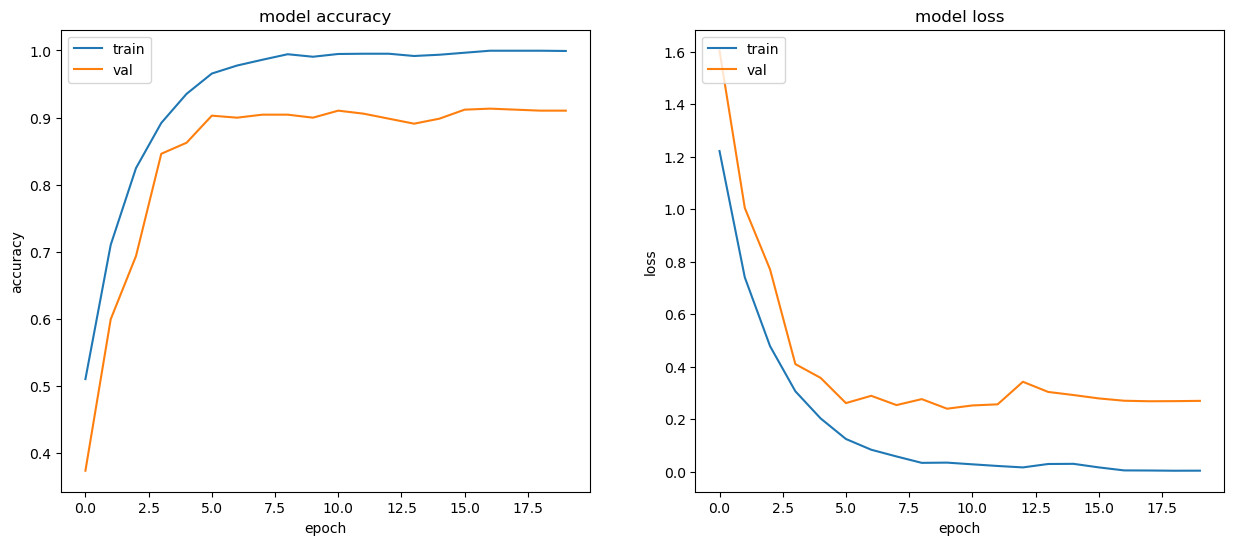

emovo


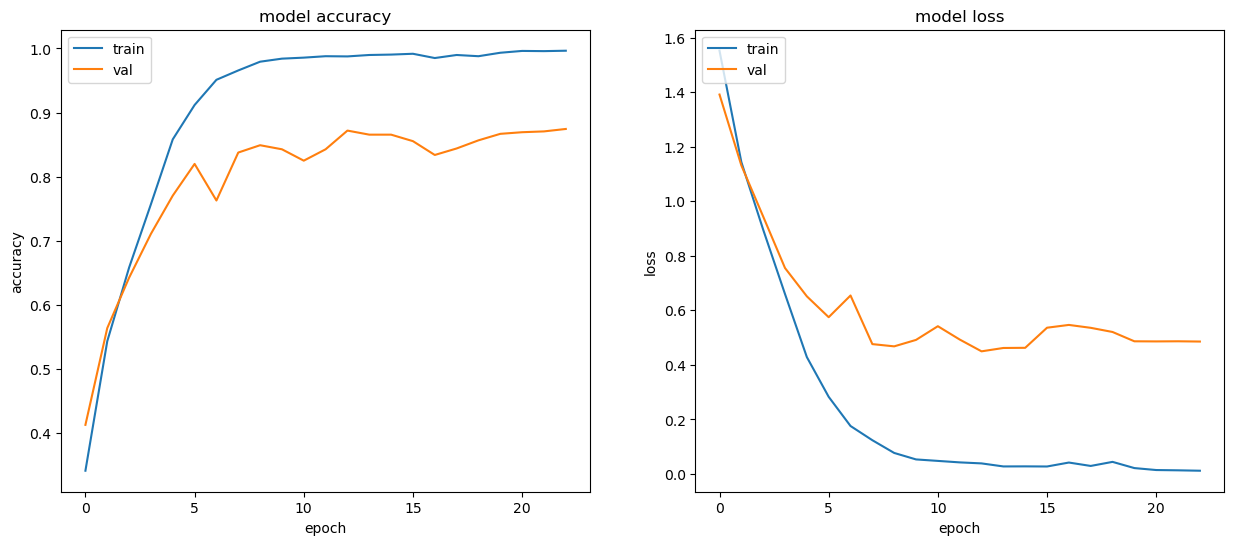

ravdess


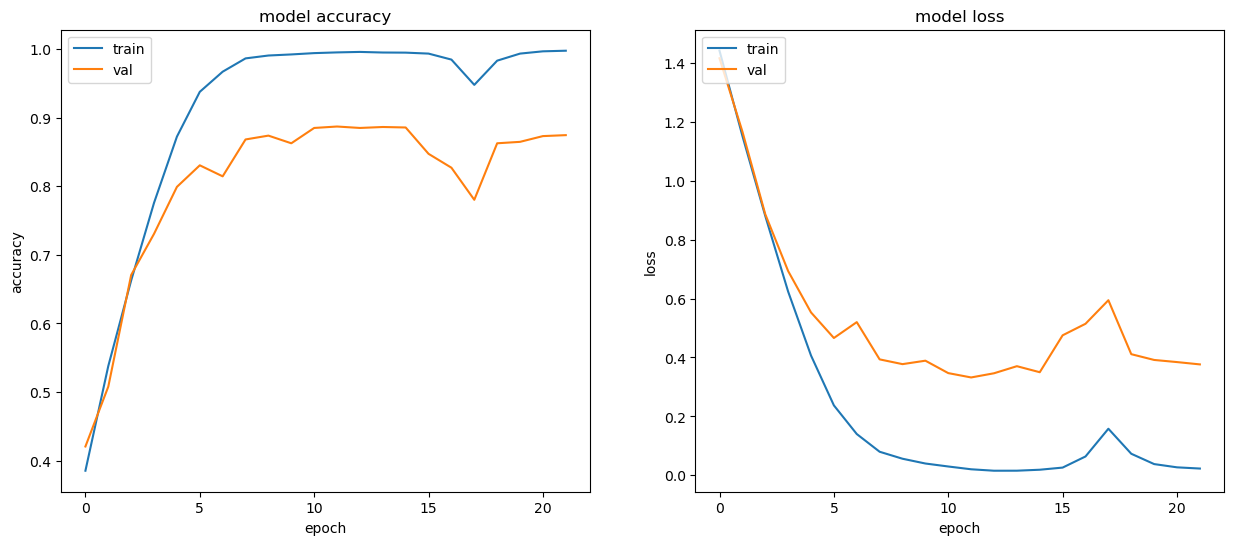

In [130]:
for s in res:
    print(s)
    plot_stats([res[s][0]])

# Algorithm hyperparameter

Adjust algorithm training hyperparameter plus minor parameter like dropout

In [135]:
def get_m2(hp):
    # Define hyper model architecture
    m = Sequential([
        InputLayer(input_shape=(261,128,1)),
        Reshape((9,29,128,1)),
        TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

        TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

        TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        TimeDistributed(Flatten()),
        
        # Tune dropout layer with values in 0 - 0.6 with stepsize of 0.3
        Dropout(hp.Float("dropout", min_value=0, max_value=0.6, step=0.3)),
        
        # Tune dropout probability (values in 0 - 0.4 with stepsize of 0.2)
        Bidirectional(LSTM(256,
                           dropout=hp.Float("lstm_dropout", min_value=0, max_value=0.4, step=0.2),
                           return_sequences=False)),
        Dense(5, activation='softmax')
    ])
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss='categorical_crossentropy',
              metrics=["accuracy"])
    return m

In [143]:
class MyTuner(kt.tuners.Hyperband):
      def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Choice("batch_size", values=[8, 16, 32, 64, 128])
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [145]:
# instantiate the tuner
tuner1 = MyTuner(get_m2,
                 objective="val_loss",
                 max_epochs=120,
                 # number of models that should be built and fit for each trial with the same hyperparameter values
                 executions_per_trial=3,
                 # the reduction factor for the number of epochs and number of models for each bracket
                 factor=15,
                 # the number of times to iterate over the full Hyperband algorithm
                 hyperband_iterations=3,
                 overwrite=True,
                 directory="/datasets/nicolas_facchinetti/kt_dir2",
                 project_name="cnnlstm2")
tuner1.search_space_summary()

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')

tuner1.search(train['emodb']['x'], train['emodb']['y'],
             epochs=100,
             validation_split=0.2,
             callbacks=[earlyStopping, reduce_lr_loss],
             verbose=2)

Trial 84 Complete [00h 06m 33s]
val_loss: 0.2943439881006877

Best val_loss So Far: 0.24255329370498657
Total elapsed time: 01h 56m 43s
INFO:tensorflow:Oracle triggered exit


In [233]:
tuner1.results_summary()

Results summary
Results in /datasets/nicolas_facchinetti/kt_dir2/cnnlstm2
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.2
learning_rate: 0.001
batch_size: 32
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0050
lstm_units: 2
Score: 0.24255329370498657
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.2
learning_rate: 0.001
batch_size: 16
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0058
Score: 0.24965617060661316
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.4
learning_rate: 0.001
batch_size: 16
tuner/epochs: 120
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.2517334371805191
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.4
learning_rate: 0.001
batch_size: 32
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0073
Score: 0.25494201978047687
Trial summary
Hyperparameters:
drop

In [152]:
tuner2 = MyTuner(get_m2,
                 objective="val_loss",
                 max_epochs=120,
                 # number of models that should be built and fit for each trial with the same hyperparameter values
                 executions_per_trial=3,
                 # the reduction factor for the number of epochs and number of models for each bracket
                 factor=15,
                 # the number of times to iterate over the full Hyperband algorithm
                 hyperband_iterations=3,
                 overwrite=True,
                 directory="/datasets/nicolas_facchinetti/kt_dir3",
                 project_name="cnnlstm3")
tuner2.search_space_summary()

tuner2.search(train['emovo']['x'], train['emovo']['y'],
             epochs=100,
             validation_split=0.2,
             callbacks=[earlyStopping, reduce_lr_loss],
             verbose=2)

Trial 84 Complete [00h 02m 01s]
val_loss: 1.5282885630925496

Best val_loss So Far: 0.36417991916338605
Total elapsed time: 02h 22m 06s
INFO:tensorflow:Oracle triggered exit


In [153]:
tuner2.results_summary()

Results summary
Results in /datasets/nicolas_facchinetti/kt_dir3/cnnlstm3
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.0
learning_rate: 0.0001
batch_size: 8
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0001
Score: 0.36417991916338605
Trial summary
Hyperparameters:
dropout: 0.0
lstm_dropout: 0.2
learning_rate: 0.0001
batch_size: 8
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0057
Score: 0.3771323362986247
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.4
learning_rate: 0.0001
batch_size: 16
tuner/epochs: 120
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.3842690885066986
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.2
learning_rate: 0.0001
batch_size: 32
tuner/epochs: 120
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.3907069265842438
Trial summary
Hyperparameters:
dropout: 0.0
lstm_dropout: 0.0
learning

In [154]:
tuner3 = MyTuner(get_m2,
                 objective="val_loss",
                 max_epochs=120,
                 # number of models that should be built and fit for each trial with the same hyperparameter values
                 executions_per_trial=3,
                 # the reduction factor for the number of epochs and number of models for each bracket
                 factor=15,
                 # the number of times to iterate over the full Hyperband algorithm
                 hyperband_iterations=3,
                 overwrite=True,
                 directory="/datasets/nicolas_facchinetti/kt_dir4",
                 project_name="cnnlstm4")
tuner3.search_space_summary()

tuner3.search(train['ravdess']['x'], train['ravdess']['y'],
             epochs=100,
             validation_split=0.2,
             callbacks=[earlyStopping, reduce_lr_loss],
             verbose=2)

Trial 84 Complete [00h 03m 28s]
val_loss: 0.3047107756137848

Best val_loss So Far: 0.24022861818472543
Total elapsed time: 03h 52m 46s
INFO:tensorflow:Oracle triggered exit


In [155]:
tuner3.results_summary()

Results summary
Results in /datasets/nicolas_facchinetti/kt_dir4/cnnlstm4
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.6
lstm_dropout: 0.2
learning_rate: 0.001
batch_size: 128
tuner/epochs: 120
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.24022861818472543
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.0
learning_rate: 0.001
batch_size: 64
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0039
Score: 0.27419041593869525
Trial summary
Hyperparameters:
dropout: 0.0
lstm_dropout: 0.4
learning_rate: 0.001
batch_size: 64
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0066
Score: 0.27864599227905273
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.2
learning_rate: 0.001
batch_size: 64
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0011
Score: 0.2835317353407542
Trial summary
Hyperparameters:
dropout: 0.0
lstm

In [184]:
# Get the optimal hyperparameters from the results
param_found = {'emodb': tuner1,
               'emovo': tuner2,
               'ravdess': tuner3}

In [185]:
for d in param_found:
    print(f'For {d} the best found paramters are:')
    print(param_found[d].get_best_hyperparameters()[0].get_config()["values"])

For emodb the best found paramters are:
{'dropout': 0.3, 'lstm_dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'tuner/epochs': 120, 'tuner/initial_epoch': 8, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0050', 'lstm_units': 2}
For emovo the best found paramters are:
{'dropout': 0.3, 'lstm_dropout': 0.0, 'learning_rate': 0.0001, 'batch_size': 8, 'tuner/epochs': 120, 'tuner/initial_epoch': 8, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0001', 'lstm_units': 2}
For ravdess the best found paramters are:
{'dropout': 0.6, 'lstm_dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'tuner/epochs': 120, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0, 'lstm_units': 2}


### Test hyperparameter

In [189]:
final_res = {}

for d in param_found:
    print(d)
    # Build model
    params = param_found[d].get_best_hyperparameters()[0]
    h_model = param_found[d].hypermodel.build(params)
    h_model.summary()
    # Train the hypertuned model
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')
    history = h_model.fit(train[d]['x'], train[d]['y'],
                          epochs=100,
                          batch_size=params.get_config()["values"]["batch_size"],
                          validation_split=0.2,
                          callbacks=[earlyStopping, reduce_lr_loss], verbose=2)
    
    # Evaluate model on test set
    results = h_model.evaluate(test[d]['x'], test[d]['y'],
                               batch_size=params.get_config()["values"]["batch_size"]
                               )
    print("Test loss, test acc:", results)
    final_res[d] = [history, results]

emodb
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_96 (TimeDis (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_97 (TimeDis (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_98 (TimeDis (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_99 (TimeDis (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_100 (TimeDi (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_101 (TimeDi (None, 9, 2, 27, 6

Epoch 18/100
395/395 - 4s - loss: 0.0331 - accuracy: 0.9943 - val_loss: 0.4426 - val_accuracy: 0.8644
Epoch 19/100
395/395 - 4s - loss: 0.0337 - accuracy: 0.9930 - val_loss: 0.5475 - val_accuracy: 0.8441

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 20/100
395/395 - 4s - loss: 0.0152 - accuracy: 0.9981 - val_loss: 0.3985 - val_accuracy: 0.8961
Epoch 21/100
395/395 - 4s - loss: 0.0130 - accuracy: 0.9987 - val_loss: 0.3919 - val_accuracy: 0.8986
Epoch 22/100
395/395 - 4s - loss: 0.0112 - accuracy: 0.9987 - val_loss: 0.3890 - val_accuracy: 0.8999
Epoch 23/100
395/395 - 4s - loss: 0.0105 - accuracy: 0.9990 - val_loss: 0.3938 - val_accuracy: 0.8973
Epoch 24/100
395/395 - 4s - loss: 0.0100 - accuracy: 0.9987 - val_loss: 0.3963 - val_accuracy: 0.8986
Epoch 25/100
395/395 - 4s - loss: 0.0097 - accuracy: 0.9987 - val_loss: 0.3966 - val_accuracy: 0.8961
Epoch 26/100
395/395 - 4s - loss: 0.0086 - accuracy: 0.9984 - val_loss: 0.4022 - val_accuracy: 0.8935
E

Epoch 44/100
45/45 - 2s - loss: 0.0215 - accuracy: 0.9948 - val_loss: 0.2243 - val_accuracy: 0.9351
Epoch 45/100
45/45 - 2s - loss: 0.0191 - accuracy: 0.9939 - val_loss: 0.2276 - val_accuracy: 0.9323
Epoch 46/100
45/45 - 2s - loss: 0.0176 - accuracy: 0.9953 - val_loss: 0.2278 - val_accuracy: 0.9351
Epoch 47/100
45/45 - 2s - loss: 0.0175 - accuracy: 0.9955 - val_loss: 0.2232 - val_accuracy: 0.9351
Epoch 48/100
45/45 - 2s - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.2217 - val_accuracy: 0.9344
Epoch 49/100
45/45 - 2s - loss: 0.0165 - accuracy: 0.9958 - val_loss: 0.2190 - val_accuracy: 0.9358
Epoch 50/100
45/45 - 2s - loss: 0.0170 - accuracy: 0.9953 - val_loss: 0.2197 - val_accuracy: 0.9344
Epoch 51/100
45/45 - 2s - loss: 0.0159 - accuracy: 0.9956 - val_loss: 0.2133 - val_accuracy: 0.9358
Epoch 52/100
45/45 - 2s - loss: 0.0183 - accuracy: 0.9937 - val_loss: 0.2144 - val_accuracy: 0.9379
Epoch 53/100
45/45 - 2s - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.2170 - val_accuracy: 0.9379


In [208]:
final_df = []
for d in final_res:
    print(f'For {d} test loss: {final_res[d][1][0]} accuracy: {final_res[d][1][1]}')
    final_df.append([final_res[d][1][0], final_res[d][1][1]])
final_df = pd.DataFrame(final_df, columns=['F loss', 'F acc'], index=final_res.keys())

For emodb test loss: 0.3060694932937622 accuracy: 0.9080047607421875
For emovo test loss: 0.3848278820514679 accuracy: 0.8804457783699036
For ravdess test loss: 0.23017199337482452 accuracy: 0.9302065968513489


emodb


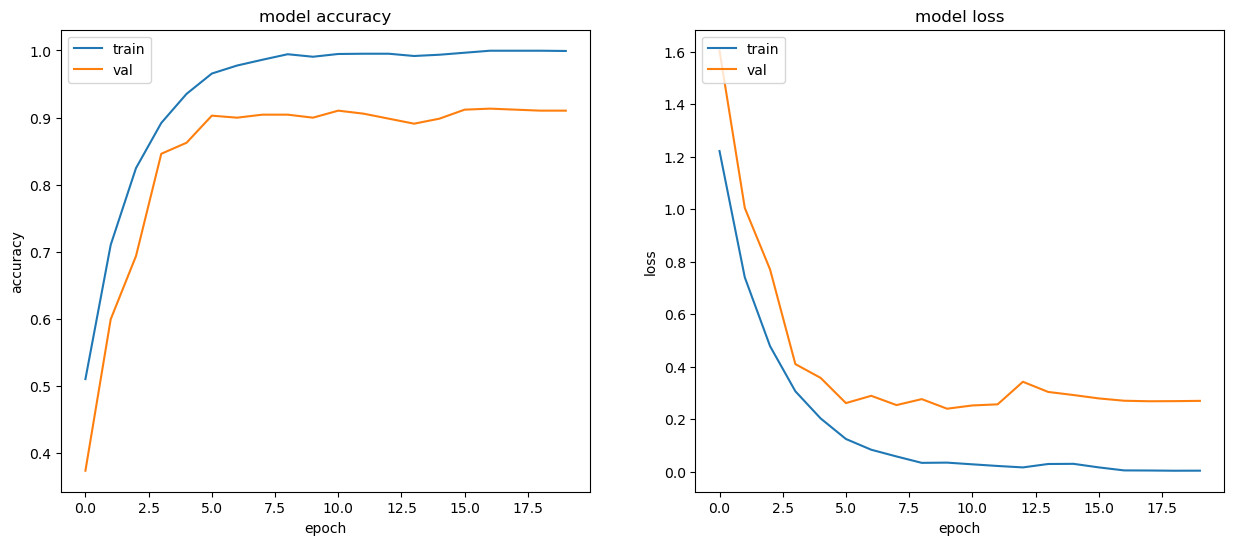

emovo


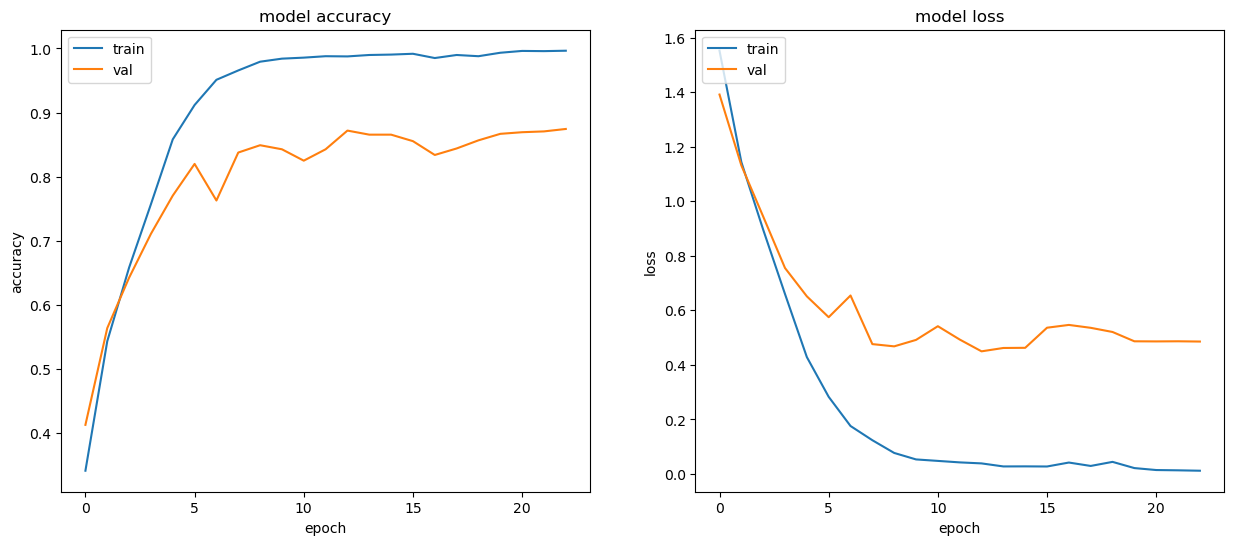

ravdess


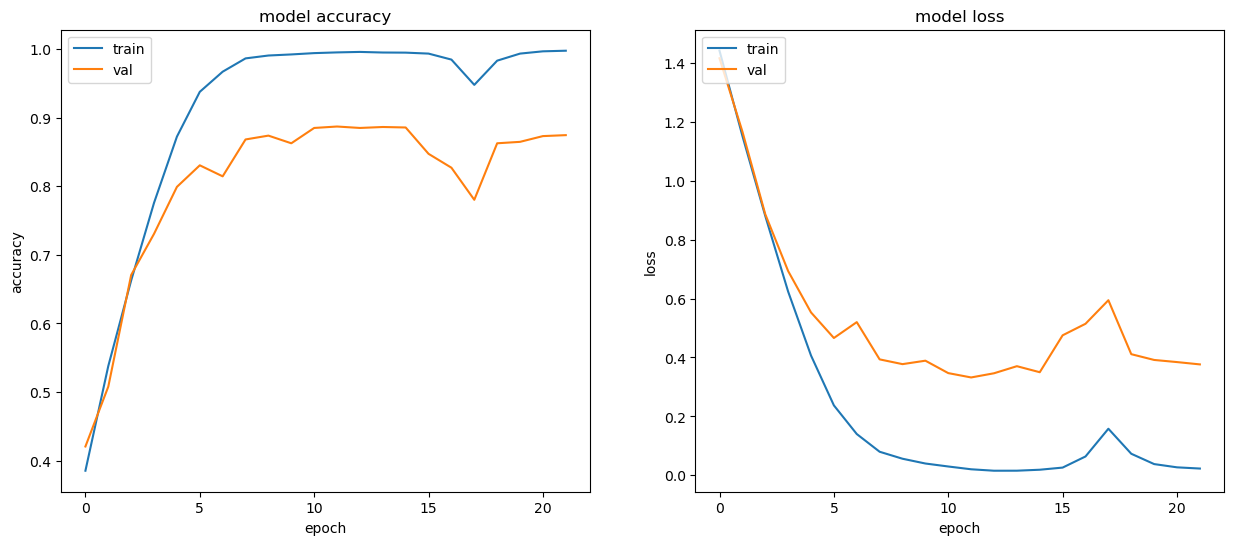

In [191]:
for s in final_res:
    print(s)
    plot_stats([res[s][0]])

# Final result

In [209]:
pd.concat([start_df, final_df], axis=1)

,S loss,S acc,F loss,F acc
emodb,0.321270,0.902031,0.306069,0.908005
emovo,0.428224,0.859169,0.384828,0.880446
ravdess,0.366705,0.878839,0.230172,0.930207


In [226]:
for d in param_found:
    print(f'For {d} the best found paramters are:')
    print(param_found[d].get_best_hyperparameters()[0].get_config()["values"])

For emodb the best found paramters are:
{'dropout': 0.3, 'lstm_dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'tuner/epochs': 120, 'tuner/initial_epoch': 8, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0050', 'lstm_units': 2}
For emovo the best found paramters are:
{'dropout': 0.3, 'lstm_dropout': 0.0, 'learning_rate': 0.0001, 'batch_size': 8, 'tuner/epochs': 120, 'tuner/initial_epoch': 8, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0001', 'lstm_units': 2}
For ravdess the best found paramters are:
{'dropout': 0.6, 'lstm_dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'tuner/epochs': 120, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0, 'lstm_units': 2}


In [225]:
param_found['emodb'].get_best_hyperparameters()[0].get_config()['values']

{'dropout': 0.3,
 'lstm_dropout': 0.2,
 'learning_rate': 0.001,
 'batch_size': 32,
 'tuner/epochs': 120,
 'tuner/initial_epoch': 8,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0050',
 'lstm_units': 2}

In [236]:
import pickle

with open('/datasets/nicolas_facchinetti/param.p', 'wb') as parameters:
    pickle.dump({d: param_found[d].get_best_hyperparameters()[0].get_config()['values']
                 for d in param_found}, parameters)